# Cantilever with a Uniform Load

This example shows how to predict the behavior of a cantilever beam which is partially
subjected to a uniform distributed load.

![](../assets/cantilever-drawing.svg)

In [1]:
using GXBeam, LinearAlgebra

nelem = 12

# create points
a = 0.3
b = 0.7
L = 1.0
n1 = n3 = div(nelem, 3)
n2 = nelem - n1 - n3
x1 = range(0, 0.3, length=n1+1)
x2 = range(0.3, 0.7, length=n2+1)
x3 = range(0.7, 1.0, length=n3+1)
x = vcat(x1, x2[2:end], x3[2:end])
y = zero(x)
z = zero(x)
points = [[x[i],y[i],z[i]] for i = 1:length(x)]

# index of endpoints for each beam element
start = 1:nelem
stop = 2:nelem+1

# create compliance matrix for each beam element
EI = 1e9
compliance = fill(Diagonal([0, 0, 0, 0, 1/EI, 0]), nelem)

# create assembly
assembly = Assembly(points, start, stop, compliance=compliance)

# set prescribed conditions (fixed right endpoint)
prescribed_conditions = Dict(
    nelem+1 => PrescribedConditions(ux=0, uy=0, uz=0, theta_x=0, theta_y=0,
    theta_z=0)
)

# create distributed load
q = 1000
distributed_loads = Dict(
    ielem => DistributedLoads(assembly, ielem; fz = (s) -> q) for ielem in
    n1+1:n1+n2
)

system, converged = static_analysis(assembly;
    prescribed_conditions = prescribed_conditions,
    distributed_loads = distributed_loads,
    linear = true)

state = AssemblyState(system, assembly;
    prescribed_conditions = prescribed_conditions)

nothing #hide

We can construct the analytical solution for this problem by integrating from the free end of the beam and applying the appropriate boundary conditions.

In [2]:
# construct analytical solution
dx = 1e-6
x_a = 0.0:dx:L
q_a = (x) -> a <= x <= b ? -q : 0 # define distributed load
V_a = cumsum(-q_a.(x_a) .* dx) # integrate to get shear
M_a = cumsum(V_a .* dx) # integrate to get moment
slope_a = cumsum(M_a./EI .* dx) # integrate to get slope
slope_a .-= slope_a[end] # apply boundary condition
deflection_a = cumsum(slope_a .* dx) # integrate to get deflection
deflection_a .-= deflection_a[end] # apply boundary condition

# get elastic twist angle
theta_a = -atan.(slope_a)

# switch analytical system frame of reference
M_a = -M_a

nothing #hide

Plotting the results reveals that the analytical and computational solutions show
excellent agreement.

In [3]:
using Plots
pyplot()
nothing #hide

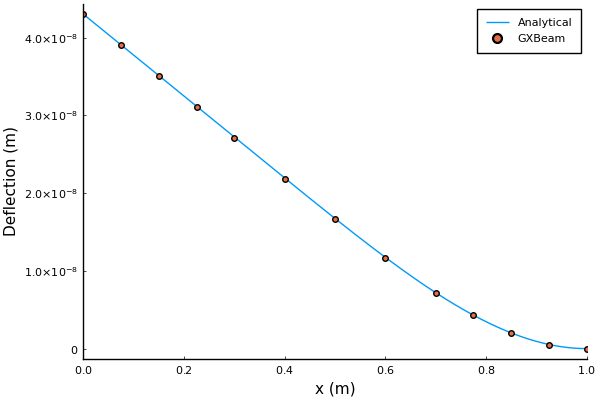

In [4]:
# deflection plot
plot(
    xlim = (0.0, 1.0),
    xticks = 0.0:0.2:1.0,
    xlabel = "x (m)",
    ylabel = "Deflection (m)",
    grid = false,
    overwrite_figure=false
    )

x = [assembly.points[ipoint][1] + state.points[ipoint].u[1] for ipoint =
    1:length(assembly.points)]
deflection = [state.points[ipoint].u[3] for ipoint = 1:length(assembly.points)]
plot!(x_a, deflection_a, label="Analytical")
scatter!(x, deflection, label="GXBeam")

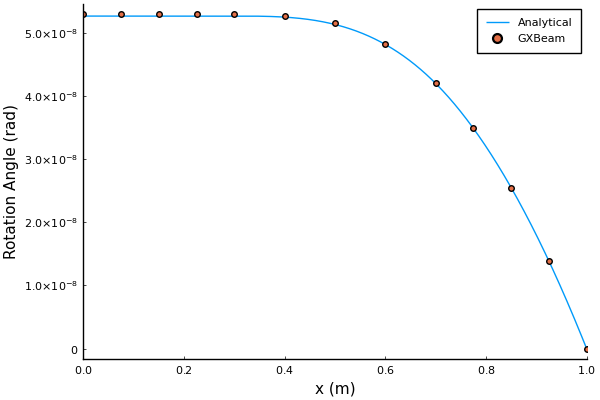

In [5]:
# elastic twist plot (euler angle)
plot(
    xlim = (0.0, 1.0),
    xticks = 0.0:0.2:1.0,
    xlabel = "x (m)",
    ylabel = "Rotation Angle (rad)",
    grid = false,
    overwrite_figure=false
    )

x = [assembly.points[ipoint][1] + state.points[ipoint].u[1]
    for ipoint = 1:length(assembly.points)]
theta = [4*atan.(state.points[ipoint].theta[2]/4) for ipoint =
    1:length(assembly.points)]
plot!(x_a, theta_a, label="Analytical")
scatter!(x, theta, label="GXBeam")

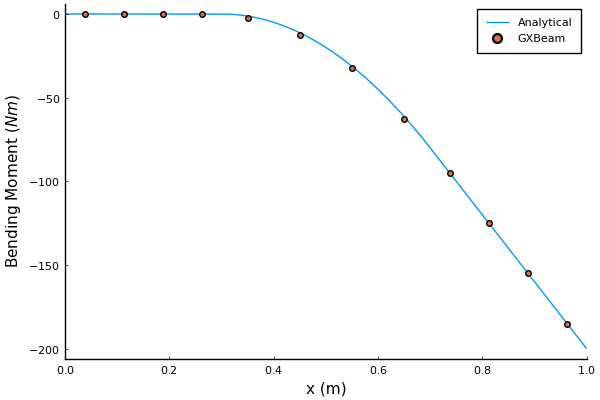

In [6]:
# bending moment plot
plot(
    xlim = (0.0, 1.0),
    xticks = 0.0:0.2:1.0,
    xlabel = "x (m)",
    ylabel = "Bending Moment (\$Nm\$)",
    grid = false,
    overwrite_figure=false
    )

x = [assembly.elements[ielem].x[1] + state.elements[ielem].u[1] for
    ielem = 1:length(assembly.elements)]
M = [state.elements[ielem].M[2] for ielem = 1:length(assembly.elements)]
plot!(x_a, M_a, label="Analytical")
scatter!(x, M, label="GXBeam")

Note that we could have easily performed a nonlinear analysis for this problem by setting
`linear=false`.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*